In [18]:
import numpy as np
import math
import scipy.stats as sc

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.animation as animation
from mpl_toolkits.mplot3d import Axes3D

import networkx as nx
import graphviz
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

import time
import pickle

import ipywidgets as wg
import IPython
from IPython.display import HTML, display, clear_output

import scipy.integrate as integrate
#from scipy.spatial import cKDTree
#from scipy import interpolate
#from scipy.signal import argrelextrema

from decimal import Decimal


#from astropy import stats


# Ising model function definitions

In [19]:
def energy_calc(lattice):
    ''' Calculated total energy of the lattice.
    
        Parameters:
            lattice: [N,N] numpy array containing only 1 and -1 values representing the spin configuration.
        
        Returns: dtype float
            Energy of the spin configuration'''
    
    a = lattice[:,1:]*lattice[:,:N-1]
    b = lattice[:N-1,:]*lattice[1:,:]
    # To ensure periodic boundary conditions the last column is multiplied with the first column of the lattice array. 
    # Same is done with the rows.
    c = lattice[0]*lattice[N-1]
    d = lattice[:,0]*lattice[:,N-1]
    # Energy:
    E = -1*(np.sum(a)+np.sum(b)+np.sum(c)+np.sum(d))
    return(E)

In [20]:
def energy_nn(lattice,x,y):
    ''' Calculate nearest neighbour interaction energy of 1 spin in the lattice.
    
        Parameters:
            lattice: dtype numpy array
                [N,N] numpy array containing only 1 and -1 values representing the spin configuration.
            
            x, y: dtype int
                The coordinates of the of the spin of interest
        
        Returns: dtype float
             nearest neighbour interaction energy of the selected spin '''
    
    s = lattice[x,y]
    nn = lattice[(x+1)%N,y] + lattice[(x-1)%N,y] + lattice[x,(y+1)%N] + lattice[x,(y-1)%N]
    E = -1*nn*s
    return(E)

In [21]:
def specific_heat(x):
    ''' Calculates specific heat.
        
        Parameters: 
            x: dtype numpy array
                One dimensional array containing the energy data (or equivalent quantity)
            
        Returns: dtype numpy array
            One dimensional array containing the specific heat data'''
    
    cv = (np.var(x))/(T**2)
    return(cv)

In [22]:
def susceptiblity(mag):
    ''' Calculates specific heat.
        
        Parameters: 
            mag: dtype numpy array
                One dimensional array containing the magnetization data
            
        Returns: dtype numpy array
            One dimensional array containing the susceptibility data'''
    
    susc = (np.var(mag))/T
    return(susc)

In [23]:
def metropolis(lattice,E,M):
    ''' Implement metropolis algorithm for a single spin flip.
    
        Parameters: 
            lattice: dtype numpy array
                [N,N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    # Select random spin (propose trial lattice with probability 1/L^2):
    x = np.random.randint(0,N)
    y = np.random.randint(0,N)
    trial_lattice = np.copy(lattice)
    trial_lattice[x,y] *= -1
    # Calculate energy difference between the old and trial configurations:
    dE = energy_nn(trial_lattice,x,y) - energy_nn(lattice,x,y)
    # Implement second stage of the metropolis algorithm:
    if dE <= 0:
        E = E + dE
        M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
        lattice[x,y] = trial_lattice[x,y]
    else:
        r = np.random.uniform(0,1)
        #p=np.exp(-dE/tau)
        if dE == 4:
            p = exp[1]
        else:
            p = exp[0]
        if r < p:
            E = E + dE
            M = M - lattice[x,y] + trial_lattice[x,y] # substract old spin value and add new spin value to the magnetisation
            lattice[x,y] = trial_lattice[x,y]
    return(lattice,E,M)

In [24]:
def Wolffbacktrack(x,y,cluster,visited):
    ''' Part of the Wolff algorithm, it checks whether a spin is already in the cluster'''
    if cluster[x,y]:
        return False
    if visited[x,y]:
        return True#False
    return True

def grow_cluster(lattice,x,y,ClusterSpin,E,M, cluster,visited):
    """ Starting from a randomly chosen spin, creates a cluster with the Wolff Algorithm.
        
        Parameters:
            lattice: dtype numpy array
                The [N,N] array representing the spin configuration
            
            x, and y: dtype int
                The coordinates of the spin that is added to the cluster
                
            ClusterSpin: dtype int
                The spin value of the cluster
            
            E and M: dtype int or float
                The energy and magnetization of the lattice
            
            cluster: dtype boolean numpy array
                [N,N] boolean numpy array indicating which spins are in the cluster
                
            visited: dtype boolean numpy array
                [N,N] boolean numpy array indicating which spins have already been trialed by the algorithm
                
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization"""
    
    old_E = energy_nn(lattice,x,y)
    lattice[x,y] *=-1
    dE = energy_nn(lattice,x,y) - old_E
    E = E + dE
    M = M - lattice[x,y]*-1 +lattice[x,y]
    #cluster.append([x,y])
    cluster[x,y] = True
    if Wolffbacktrack((x+1)%N,y, cluster, visited):
        E, M = try_add(lattice,(x+1)%N,y,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack((x-1)%N,y, cluster,visited):
        E, M = try_add(lattice,(x-1)%N,y,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack(x,(y+1)%N, cluster,visited):
        E, M = try_add(lattice,x,(y+1)%N,ClusterSpin,E,M, cluster,visited)
    if Wolffbacktrack(x,(y-1)%N, cluster,visited):
        E, M = try_add(lattice,x,(y-1)%N,ClusterSpin,E,M, cluster,visited)
    return(lattice,E,M)

def try_add(lattice,x,y,ClusterSpin,E,M, cluster, visited):
    """Checks of neighbor belongs to cluster, if so then add neighbor to cluster with a certain probability"""
    
    s_help = lattice[x,y]
    #global tau
    if ((s_help<0) != (ClusterSpin<0)):
        r = np.random.uniform(0,1)
        if r < (1-A_wolff):
            lattice, E, M = grow_cluster(lattice,x,y,ClusterSpin,E,M, cluster,visited)
        else:
            visited[x,y] = True
    return(E,M)

def Wolff(lattice,E,M):
    ''' Implements the wolff algorithm for a single timestep.
        
        Parameters: 
            lattice: dtype numpy array
                [N,N] array representing the lattice
            E: dtype float or int
                Energy of the lattice
            M: dtype float or int
                Magnetization of the lattice
        Returns: dtype tuple
            Tuple containing the updated lattice and the corresponding energy and magnetization'''
    
    x = np.random.randint(0,N)
    y = np.random.randint(0,N)
    cluster = np.full((N,N), False, dtype=bool)
    visited = np.full((N,N), False, dtype=bool)
    clusterspin = lattice[x,y]*-1
    lattice, E, M = grow_cluster(lattice,x,y,clusterspin, E, M, cluster,visited)
    return(lattice,E,M)

# 1D correspondence function definitions

In [25]:
def oneD_create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the 1D lattice
    
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map: dtype numpy array
                [N] boolean array containing True if bond is present or False if not. For example spin lattice [1, -1, 1, 1]
    """
    lat = np.array(lat)
    a = lat[1:]-lat[0:len(lat)-1]; b = lat[0]-lat[len(lat)-1]
    c = np.append(a,b)
    f_map = (c == 0)
    return(f_map)

In [26]:
def oneD_backtrack(x,vis,fm,cl):
    """ Part of the 1D cluster decomposition. It recursively checks whether neighbouring spin should be added to the cluster
    """
    if not vis[x]:
        vis[x] = True
        cl.append(x)
        if fm[x]:
            vis, cl = oneD_backtrack((x+1)%len(fm),vis,fm,cl)
        if fm[(x-1)%len(fm)]:
            vis, cl = oneD_backtrack((x-1)%len(fm),vis,fm,cl)
    return(vis,cl)

In [27]:
def oneD_cluster_decomp(lat):
    """ Decomposes the 1D spin lattice into clusters, i.e. creates list of cluster arrays. A cluster array contains the indices 
        of the spins in a cluster
        
        Input:
            lat: dtype numpy array
                [N] array containing only 1 and -1 values representing the spin configuration
                
        Returns:
            cls: dtype list
                list of cluster arrays. Each cluster array contains the indices of the spins in that cluster
    """
    visited = np.full((len(lat)), False)
    frozen_map = oneD_create_frozen_map(lat)
    #zeros = np.where(np.array(lat)==0)[0]
    #tried = dict.fromkeys(zeros,False)
    cls = []
    for i in range(len(lat)):
        clu = []
        visited, clu = oneD_backtrack(i,visited,frozen_map,clu)
        if len(clu) > 0:
            cls.append(clu)
    return(cls)

# 2D correspondence function definitions

In [28]:
def create_frozen_map(lat):
    """ Creates a boolean map of (freezes) all bonds (nn interactions) in the lattice
    
        Input:
            lat: dtype numpy array
                [N,N] array containing only 1 and -1 values representing the spin configuration
            
        Returns:
            f_map_x: dtype numpy array
                [N,N] boolean array containing True if nn bond is present in the x-direction (horizontal), or False if not.
                
            f_map_y: dtype numpy array
                [N,N] boolean array containing True if nn bond is present in the y-direction (vertical), or False if not.
    """
    lat = np.array(lat)
    a = lat[:,1:]-lat[:,:-1]; b = lat[:,0]-lat[:,-1]
    b = np.reshape(b,(len(lat),1))
    c = np.append(a,b,axis=1)
    f_map_y = (c == 0)
    # same for y
    a = lat[1:]-lat[:-1]; b = lat[0]-lat[-1]
    b = np.reshape(b,(1,len(lat)))
    c = np.append(a,b,axis=0)
    f_map_x = (c == 0)
    return(f_map_x, f_map_y)

In [29]:
def backtrack(x,y,vis,fmx,fmy,cl):
    """ Part of the cluster decomposition. It recursively checks whether neighbouring spin should be added to the cluster
    """
    if not vis[x,y]:
        vis[x,y] = True
        cl.append([x,y])
        if fmx[x,y]:
            vis, cl = backtrack((x+1)%len(fmx),y,vis,fmx,fmy,cl)
        if fmx[(x-1)%len(fmx),y]:
            vis, cl = backtrack((x-1)%len(fmx),y,vis,fmx,fmy,cl)
        if fmy[x,y]:
            vis, cl = backtrack(x,(y+1)%len(fmy),vis,fmx,fmy,cl)
        if fmy[x,(y-1)%len(fmy)]:
            vis, cl = backtrack(x,(y-1)%len(fmy),vis,fmx,fmy,cl)
    return(vis,cl)

In [30]:
def cluster_decomp(lat):
    """ Decomposes the spin lattice into clusters, i.e. creates list of cluster arrays. A cluster array contains the indices of 
        the spins in a cluster
        
        Input:
            lat: dtype numpy array
                [N,N] array containing only 1 and -1 values representing the spin configuration
                
        Returns:
            cls: dtype list
                list of cluster arrays. Each cluster array contains the indices of the spins in that cluster
    """
    visited = np.full((len(lat),len(lat)), False)
    frozen_map_x, frozen_map_y = create_frozen_map(lat)
    #zeros = np.where(np.array(lat)==0)[0]
    #tried = dict.fromkeys(zeros,False)
    cls = []
    for i in range(len(lat)):
        for j in range(len(lat)):
            clu = []
            visited, clu = backtrack(i,j,visited,frozen_map_x,frozen_map_y,clu)
            if len(clu) > 0:
                cls.append(clu)
    return(cls)

In [31]:
def boundary_pos():
    """ Creates dictionary, which labels the spins of lattice (assigning a number from 0 to N^2) and registers their position
        in the lattice
        
        Returns:
            pos: dtype dictionary
                dictionary of (boundary) spins which registers their position in the lattice     
    """
    tel = 0
    pos = {i: [] for i in range(N**2)}
    for j in range(N):
        for i in range(N):
            pos[tel] = [i,j,0]
            tel += 1
    return(pos)

In [32]:
def construct_graph(lat):
    """ Construct graph from spin lattice according to the AoSD procedure
        
        Input: 
            lat: dtype numpy array
                [N,N] array containing only 1 and -1 values representing the spin configuration
            
        Returns: 
            Gr: dtype networkx graph
                AoSD graph 
            
            pos: dtype dictionary
                extended boundary position dictionary to a dictionary of all the nodes/spins of the network, i.e. all 
                nodes/spins of the network are labeled by a number and the dictionary registers their (3D) position in space
                
            alm: dtype scalar
                allometric scale of the constructed network
    """
    # Initialize
    lats = []
    lats.append(lat)
    shell = 0
    n_nodes_shell = np.array(lats[shell]).size
    add = 0
    dz = 1
    alm = {}

    Gr = nx.Graph()
    for i in range(N**2):
        Gr.add_node(i)

    pos = boundary_pos()
            
    while(n_nodes_shell>1):
        new_lat = []
        if shell == 0:
            # perform step 1 of the coarse grain procedure with 2D boundary lattice
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                new_pos = list(np.round(np.mean(clusters[i],axis=0),1))
                new_pos.append((shell+1)*dz)
                pos.update({n_Gr: new_pos})
                a = len(clusters[i])+1; c = a+len(clusters[i])
                alm.update({n_Gr: [a,c]})
                for j in clusters[i]:
                    value += lats[shell][j[0],j[1]]
                    lat_node = j[0]+j[1]*N
                    Gr.add_edge(n_Gr,lat_node)
                new_lat.append(value)
        elif shell%2 == 0:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = oneD_cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                new_pos = []
                a = 1; c = 0
            
                for j in clusters[i]:
                    value += lats[shell][j]
                    Gr.add_edge(n_Gr,j+add)
                    new_pos.append(pos[j+add])
                    a += alm[j+add][0]; c += alm[j+add][1]
                new_pos = list(np.round(np.mean(np.array(new_pos),axis=0),1))
                new_pos[2] = (shell+1)*dz
                pos.update({n_Gr: new_pos})
                c += a
                alm.update({n_Gr: [a,c]})
                new_lat.append(value)
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            r = n_nodes_shell%2
            l = n_nodes_shell-r
            for k in np.arange(0,l,2):
                value = 0
                n_Gr = nx.number_of_nodes(Gr); Gr.add_node(n_Gr)
                #print('k+add',k+add)
                #print('alm', alm)
                new_pos = []
                new_pos.append(pos[k+add]); new_pos.append(pos[k+1+add])
                a = alm[k+add][0]+alm[k+1+add][0]+1; c = alm[k+add][1]+alm[k+1+add][1] 
                value = lats[shell][k]+lats[shell][k+1]
                
                # if three clusters remain:
                if (k+1)==(l-1) and r!=0:
                    value += lats[shell][l]
                    Gr.add_edge(n_Gr,l+add)
                    new_pos.append(pos[l+add])
                    a += alm[l+add][0]; c += alm[l+add][1]
                
                if value == 0:
                    value = np.random.choice([-1,1])
                else:
                    value = value/abs(value)
                Gr.add_edge(n_Gr,k+add); Gr.add_edge(n_Gr,k+1+add)
                new_pos = list(np.round(np.mean(np.array(new_pos),axis=0),1))
                new_pos[2] = (shell+1)*dz
                pos.update({n_Gr: new_pos})
                c += a
                alm.update({n_Gr: [a,c]})
                new_lat.append(value)
    
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = np.array(lats[shell]).size
    alm = alm[n_Gr]
    return(Gr, pos, alm)

In [33]:
def construct_graph_eff(lat):
    # Initialize
    lats = []
    lats.append(lat)
    shell = 0
    n_nodes_shell = np.array(lats[shell]).size
    n_Gr = n_nodes_shell-1
    add = 0
    dz = 1
    alm = {}
            
    while(n_nodes_shell>1):
        new_lat = []
        if shell == 0:
            # perform step 1 of the coarse grain procedure with 2D boundary lattice
            clusters = cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr += 1
                a = len(clusters[i])+1; c = a+len(clusters[i])
                alm.update({n_Gr: [a,c]})
                for j in clusters[i]:
                    value += lats[shell][j[0],j[1]]
                    lat_node = j[0]+j[1]*N
                new_lat.append(value)
        elif shell%2 == 0:
            # perform step 1 of the coarse grain procedure (create domain branches)
            clusters = oneD_cluster_decomp(lats[shell])
            # go through clusters
            for i in range(len(clusters)):
                value = 0
                n_Gr += 1
                a = 1; c = 0
            
                for j in clusters[i]:
                    value += lats[shell][j]
                    a += alm[j+add][0]; c += alm[j+add][1]
                c += a
                alm.update({n_Gr: [a,c]})
                new_lat.append(value)
        else:
            # peform step 2 of the coarse grain procedure (average over domains)
            r = n_nodes_shell%2
            l = n_nodes_shell-r
            for k in np.arange(0,l,2):
                value = 0
                n_Gr += 1
                a = alm[k+add][0]+alm[k+1+add][0]+1; c = alm[k+add][1]+alm[k+1+add][1] 
                value = lats[shell][k]+lats[shell][k+1]
                
                # if three clusters remain:
                if (k+1)==(l-1) and r!=0:
                    value += lats[shell][l]
                    a += alm[l+add][0]; c += alm[l+add][1]
                
                if value == 0:
                    value = np.random.choice([-1,1])
                else:
                    value = value/abs(value)
                c += a
                alm.update({n_Gr: [a,c]})
                new_lat.append(value)
    
        lats.append(new_lat)
        shell += 1
        add += n_nodes_shell; n_nodes_shell = np.array(lats[shell]).size
    alm = alm[n_Gr]
    return(alm)

In [34]:
N = 2
lat = np.ones((N,N))
lat[0,0] = -1
lat[1,1] = -1
print(lat)
allom = construct_graph_eff(lat)
print(allom)

[[-1.  1.]
 [ 1. -1.]]
[11, 33]


In [35]:
def bulk_plot(ax, Gr, pos):
    """ Creates 3D plot of the network (boundary+bulk), i.e. its nodes and edges
    
        Input:
            ax: dtype matplotlib axis (projection 3d)
            
            Gr: dtype networkx graph
                the AoSD graph
            
            pos: dtype dictionary
                position dictionary of the nodes/spins of the network    
    """
    hs = 1
    ax.cla()
    # Loop on the pos dictionary to extract the x,y,z coordinates of each node
    for key, value in pos.items():
        xi = value[0]; yi = value[1]; zi = value[2]
        ax.scatter(hs*xi, hs*yi, zi, s=10, c='r')
        ax.text(hs*xi,hs*yi,zi,key)
        ax.set_zlim3d(0,4)
    
    # Loop on the list of edges to get the x,y,z, coordinates of the connected nodes
    # Those two points are the extrema of the line to be plotted
    for i,j in enumerate(Gr.edges()):
        x = np.array((pos[j[0]][0], pos[j[1]][0]))
        y = np.array((pos[j[0]][1], pos[j[1]][1]))
        z = np.array((pos[j[0]][2], pos[j[1]][2]))
    
        # Plot the connecting lines
        ax.plot(hs*x, hs*y, z, c='k',linewidth=0.8,alpha=0.6)
        
    ax.set_axis_off()
    return()

# Exhibition

In [36]:
def exhibition(temp, save):
    t_sim = 20
    global T
    T = temp
    #global exp
    #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability (only
    # need first two values for metropolis)
    global A_wolff
    A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
    # Initialize lattice
    lattice = -1*np.ones((N,N))  
    #lattice = np.random.choice([1,-1],size=(N,N))

    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lattice); M = np.sum(lattice) 

    # Initialise figure
    %matplotlib notebook
    fig = plt.figure(figsize=(10,5)); plt.title('N=%d, T=%.2f'%(N**2,temp)); plt.axis('off') 
    grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[2:8,:3]); ax1.set_axis_off()
    ax2 = fig.add_subplot(grid[:,3:],projection='3d'); ax2.set_zlim3d(0,4)

    # Set boundary plot
    x, y = np.meshgrid(range(N),range(N), indexing='ij')
    # Add labels
    pos = boundary_pos()
    for i in pos:
        ax1.annotate(i,(pos[i][0],pos[i][1]))

    for j in range(t_sim):
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lattice, E, M = metropolis(lattice,E,M) 
            
        # Perform cluster flip using wolff algorithm:
        lattice, E, M = Wolff(lattice,E,M) 
        
        # Update boundary
        ax1.scatter(x,y,s=100,c=lattice)
    
        # Update bulk
        bulkG, positions, allometric = construct_graph(lattice)
        bulk_plot(ax2, bulkG, positions)
    
        fig.canvas.draw()
        #time.sleep(0.1)
        
    if save:
        plt.savefig('2DcorrespondenceN=%dT=%d'%(N**2,temp))

In [37]:
N = 6
wg.interact_manual(exhibition, temp=(0.1,3,0.01), save=False)

interactive(children=(FloatSlider(value=1.55, description='temp', max=3.0, min=0.1, step=0.01), Checkbox(value…

<function __main__.exhibition(temp, save)>

# Results

In [38]:
def simulate(lat):
    # Initialise:
    configs = np.zeros([t_sim,N,N]) # [t_sim,N,N] array to store configurations of the lattice
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    graphs = [] # list to store (bulk)graphs corresponding to the lattice during simulation
    graph_positions = [] # list to store 3D coordinates of nodes of the (bulk)graphs
    allometric = np.zeros([t_sim,2])
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lat); M = np.sum(lat) 
    
    # Construct (bulk)graph
    bulkG, pos, alm = construct_graph(lat)
    
    t1 = time.time()    
    # Simulation:
    for i in range(t_sim):
        # Store data:
        configs[i] = lat; en[i] = E; mag[i] = M
        graphs.append(bulkG); graph_positions.append(pos)
        allometric[i] = alm
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M)
        
        bulkG, pos, alm = construct_graph(lat)
                
        t2 = time.time()
        
        if i%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(i/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if i == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, graphs, graph_positions, allometric)


In [39]:
def simulate_eff(lat):
    # Initialise:
    configs = np.zeros([t_sim,N,N]) # [t_sim,N,N] array to store configurations of the lattice
    en = np.zeros(t_sim); mag = np.zeros(t_sim) # Arrays to store the energy E and magnetisation M 
    allometric = np.zeros([t_sim,2])
    
    # Calculate energy and magnetisation by performing a sweep over the whole lattice (only once, as at each step it is updated)
    E = energy_calc(lat); M = np.sum(lat) 
    
    # Construct (bulk)graph
    alm = construct_graph_eff(lat)
    
    t1 = time.time()    
    # Simulation:
    for i in range(t_sim):
        # Store data:
        configs[i] = lat; en[i] = E; mag[i] = M
        allometric[i] = alm
        
        # Perform one MCS using metropolis algorithm:
        #for k in range(N**2):
            #lat, E, M = metropolis(lat,E,M)
            
        # Perform cluster flip using wolff algorithm:
        lat, E, M = Wolff(lat,E,M)
        
        alm = construct_graph_eff(lat)
                
        t2 = time.time()
        
        if i%(t_sim/10) == 0: 
            print("Simulation progress : ", np.around(i/t_sim*100), "% ", "Time: ", np.around(t2-t1, 3), "s", end="\r", 
                  flush=True) 
        if i == t_sim-1:
            print("\n Total time: ", np.around(t2-t1, 3), "s")
                
    return(configs, en, mag, allometric)


### Animation

In [71]:
def make_anim(configs, graphs, graph_positions, temperatures, t):
    # Initialise figure
    fig = plt.figure(figsize=(10,5)); plt.axis('off') 
    grid = plt.GridSpec(10, 10, hspace=0.2, wspace=0.2)
    ax1 = fig.add_subplot(grid[2:9,:4]); ax1.set_axis_off()
    ax2 = fig.add_subplot(grid[:,4:],projection='3d'); ax2.set_axis_off()
    N_frames = configs.shape[0]; L = configs.shape[1]
    x, y = np.meshgrid(range(L),range(L), indexing='ij')
    
    def init():
        # Create boundary plot
        ax1.scatter(x,y,s=100,c=configs[0])
        # Add labels
        pos = boundary_pos()
        for i in pos:
            ax1.annotate(i,(pos[i][0],pos[i][1]))
            
        # Create bulk plot
        bulkG = graphs[0]
        bulk_pos = graph_positions[0]
        bulk_plot(ax2, bulkG, bulk_pos)
        return()
    
    def animate(i):
        if i%t == 0:
            tel = int(i/t)
            temp = temperatures[tel]
            fig.suptitle('N=%d, T=%.1f'%(N,temp))
        
        # Update boundary
        ax1.scatter(x,y,s=100,c=configs[i])
        
        # Update bulk
        bulkG = graphs[i]
        bulk_pos = graph_positions[i]
        bulk_plot(ax2, bulkG, bulk_pos)
        return()
    
    anim =animation.FuncAnimation(fig, animate, init_func=init, frames=N_frames, interval=750)
    plt.close(fig)
    return(anim)

In [76]:
run = False

if run:
    # Set system parameters (note that these are global!):
    N = 6 # Lattice number
    temperatures = np.linspace(0.1, 8, 20) # Temperature (critical at around 2.27)
    #temperatures = np.sort(np.random.normal(2.28,0.6,50))# Temperature (critical at around 2.27)
    t_eq = 2500
    t_prod = 5
    t_sim = t_eq + t_prod

    animC = []; animG = []; animGP = []

    # Initial lattice configuration
    lattice = -1*np.ones((N,N))  
    # lattice = np.random.choice([1,-1],size=(N,N))
  

    for T in temperatures:
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        # probability (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T)
        C, E, M, G, GP, ALM = simulate(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
    
        animC.append(C[t_eq:]); animG.append(G[t_eq:]); animGP.append(GP[t_eq:])
    
    animC = np.array(animC); animC = animC.reshape(animC.shape[0]*animC.shape[1],animC.shape[2],animC.shape[3])
    animG = np.array(animG); print(animG.shape); animG = animG.reshape(animG.shape[0]*animG.shape[1])
    animGP = np.array(animGP); animGP = animGP.reshape(animGP.shape[0]*animGP.shape[1])
    

(20, 5)


In [78]:
run = False

if run:
    anim = make_anim(animC,animG,animGP,temperatures,t_prod)
    HTML(anim.to_html5_video())

In [79]:
HTML(anim.to_html5_video())

In [75]:
save = False
if save:
    anim.save('AoSD2DcorrespondenceAnimation.mp4')

### Equilibrium

In [40]:
run = False
# Set system parameters (note that these are global!):
N = 32 # Lattice number
lowRange = np.linspace(0.1, 2.26, 3); highRange = np.linspace(2.28, 6, 4)
#print(lowRange, highRange)
temperatures = np.sort(np.concatenate((lowRange, highRange))) # Temperature (critical at around 2.27)
t_eq = 1500
t_prod = 0
t_sim = t_eq + t_prod


mag_data = []; en_data = []; nng_data = []; alm_data = []

lattice = np.ones((N,N))

if run:
    for T in temperatures:
        #lattice = np.random.choice([1,-1],size=(N,N)) # Initial lattice configuration
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff

        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, ALM = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = np.copy(C[-1])
        
        nng = ALM[:,0]; alm = ALM[:,1]
    
        mag_data.append(abs(M))
        en_data.append(E)
        nng_data.append(nng)
        alm_data.append(alm)

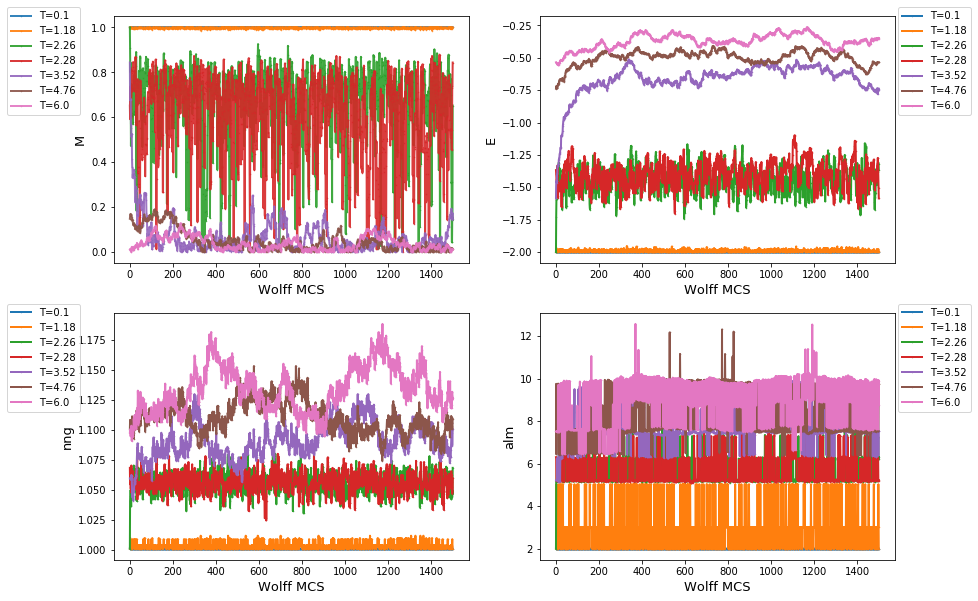

In [42]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3); ax4 = fig.add_subplot(2,2,4)
save = False

if not save:
    EqData = pickle.load(open('2DeqData.p', 'rb'))
    t_sim = EqData['t_sim']; N = EqData['N']; mag_data = EqData['mag_data']; en_data = EqData['en_data'] 
    nng_data = EqData['nng_data']; alm_data = EqData['alm_data']

t = np.arange(t_sim)

for i, item in enumerate(temperatures):
    ax1.plot(t,mag_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1, alpha=0.9)
    ax2.plot(t,en_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1)
    ax3.plot(t,nng_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1)
    ax4.plot(t,alm_data[i]/(N**2), label = ('T={}'.format(np.around(item,2))), marker='.', linewidth=2, markersize=1)
    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('M', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('E', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('nng', fontsize=13)
ax4.set_xlabel('Wolff MCS',fontsize=13); ax4.set_ylabel('alm', fontsize=13)
ax1.legend(loc=(-0.3,0.6)); ax2.legend(loc=(1.01,0.6)); ax3.legend(loc=(-0.3,0.6)); ax4.legend(loc=(1.01,0.6))


if save:
    plt.savefig('2Dequitime')
    EqData = {'t_sim': t_sim, 'N': N, 'mag_data': mag_data, 'en_data': en_data, 'nng_data': nng_data, 'alm_data': alm_data}
    pickle.dump(EqData, open('2DeqData.p', 'wb'))

### Correlation function 

In [43]:
def corr_func_calc(x):
    ''' Calculated the correlation function of a data set (Magnetization/energy/specific heat/susceptibility)

        Parameters: 
            x: dtype numpy array or list
                One dimensional list or array containing the data
        
        Returns: dtype numpy array
            The correlation function'''
    
    t_max = len(x)
    c = np.zeros(t_max)
    for i in range(t_max):
        denom = t_max-i
        c[i] = (np.sum(x[:t_max-i]*x[i:t_max])/denom)-(np.sum(x[:t_max-i])*np.sum(x[i:t_max])/(denom**2))
    c = c/c[0]
    return(c)

In [44]:
def corr_time(corr, acc):
    ''' Automatically fits the correlation function to an exponention function and finds the decay length
        
        Parameters:
            corr: dtype numpy array
                The correlation function of a data set
            
        Returns: dtype float
            The decay length of the exponential fit'''
    
    l = 0; k = np.argmax(corr<0)-1
    corr_decay = np.log(corr[l:k])
    t = np.arange(t_prod)
    #print(len(t[l:k]),len(corr_decay))
    slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay)

    while r_val**2<acc:
        k -= 1
        slope, cep, r_val, _, err = sc.linregress(t[l:k], corr_decay[:k])
    
    #return (slope, cep, r_val, err, t[l:k], corr_decay[:k])
    #plt.plot(t[l:k],corr_decay[:k])
    #plt.plot(t[l:k],cep+slope*t[l:k])
    #plt.show()
    tau = -1/slope
    return(tau)

In [45]:
def corr_and_error(x):
    corr = corr_func_calc(x)
    if (corr[0]==np.nan) or (np.argmax(corr<0)<3):
        tau = 0
        sigma = np.std(x)
    else: 
        tau = corr_time(corr, 0.98)
        sigma = np.sqrt(2*(tau/len(x))*np.std(x))                    
    return(corr, tau, sigma)
       

Set temperatures:

In [46]:
lowRange = np.linspace(0.01, 1, 4); midlowRange = np.linspace(1.2, 2, 7)
clowRange = 2.27 - np.geomspace(0.009, 0.16, 6); chighRange = 2.26 + np.geomspace(0.009, 0.7, 9)
midhighRange = np.linspace(3.3, 5, 5); highRange = np.linspace(5.7, 8, 4)

temperatures = np.sort(np.concatenate((lowRange,midlowRange, clowRange, chighRange, midhighRange, highRange)))
print(len(temperatures))
print(temperatures[:])
#print('diff')
#print(np.diff(temperatures[:]))

new = False
if new:
    possibleScales = []
    LcorrEdata = []; LtauEdata = []
    LcorrMdata = []; LtauMdata = []
    Lcorr_nng_data = []; Ltau_nng_data = []
    Lcorr_alm_data = []; Ltau_alm_data = []
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data, 'Lcorr_alm_data': Lcorr_alm_data, 'Ltau_alm_data': Ltau_alm_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

35
[0.01       0.34       0.67       1.         1.2        1.33333333
 1.46666667 1.6        1.73333333 1.86666667 2.         2.11
 2.18002031 2.21939785 2.24154271 2.25399639 2.261      2.269
 2.27550956 2.28672738 2.30605888 2.33937254 2.39678145 2.49571334
 2.6662011  2.96       3.3        3.725      4.15       4.575
 5.         5.7        6.46666667 7.23333333 8.        ]


In [47]:
run = False

if run:
    #run = False
    # Set system parameters (note that these are global!):
    N = 28
    t_eq = 1000
    t_prod = 500
    t_sim = t_eq + t_prod
    
    corrEdata = []; tauEdata = np.zeros(len(temperatures)) 
    corrMdata = []; tauMdata = np.zeros(len(temperatures)) 
    corr_nng_data = []; tau_nng_data = np.zeros(len(temperatures)) 
    corr_alm_data = []; tau_alm_data = np.zeros(len(temperatures)) 
    
    # Initial lattice configuration  
    lattice = -1*np.ones((N,N))  
    #lattice = np.random.choice([1,-1],size=(N,N))
    
    for j,T in enumerate(temperatures):
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff

        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, ALM = simulate_eff(lattice)
        clear_output(wait=True)
        
        lattice = np.copy(C[-1])
        
        nng = ALM[:,0]; alm = ALM[:,1]
        
        corrE, tauE, sigmaE = corr_and_error(E[t_eq:])
        corrM, tauM, sigmaM = corr_and_error(abs(M[t_eq:]))
        corr_nng, tau_nng, sigma_nng = corr_and_error(nng[t_eq:])
        corr_alm, tau_alm, sigma_alm = corr_and_error(alm[t_eq:])
        
        #if tau_alm > 30:
                #print('fail')
                #print(T)
                #print(tau_alm)
                #run = True
                #break
        
        corrEdata.append(corrE); tauEdata[j] = tauE
        corrMdata.append(corrM); tauMdata[j] = tauM
        corr_nng_data.append(corr_nng); tau_nng_data[j] = tau_nng
        corr_alm_data.append(corr_alm); tau_alm_data[j] = tau_alm
    

tau_alm_data

idx = 2

#LcorrEdata[idx] = corrEdata; LtauEdata[idx] = tauEdata
#LcorrMdata[idx] = corrMdata; LtauMdata[idx] = tauMdata 
#Lcorr_nng_data[idx] = corr_nng_data; Ltau_nng_data[idx] = tau_nng_data
Lcorr_alm_data[idx] = corr_alm_data; Ltau_alm_data[idx] = tau_alm_data

CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 'LtauEdata': LtauEdata, 
            'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 'Ltau_nng_data': Ltau_nng_data,
            'Lcorr_alm_data': Lcorr_alm_data, 'Ltau_alm_data': Ltau_alm_data} 
pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

In [49]:
CorrData = pickle.load(open('2DcorrData.p', 'rb'))
possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
Lcorr_nng_data = CorrData['Lcorr_nng_data']; Ltau_nng_data = CorrData['Ltau_nng_data']
Lcorr_alm_data = CorrData['Lcorr_alm_data']; Ltau_alm_data = CorrData['Ltau_alm_data']

save = False
if save:
    possibleScales.append(N)
    LcorrEdata.append(corrEdata); LtauEdata.append(tauEdata)
    LcorrMdata.append(corrMdata); LtauMdata.append(tauMdata)
    Lcorr_nng_data.append(corr_nng_data); Ltau_nng_data.append(tau_nng_data)
    Lcorr_alm_data.append(corr_alm_data); Ltau_alm_data.append(tau_alm_data)
    
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data, 'Lcorr_alm_data': Lcorr_alm_data, 'Ltau_alm_data': Ltau_alm_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

In [50]:
save = False

if not save:
    CorrData = pickle.load(open('2DcorrData.p', 'rb'))
    possibleScales = CorrData['possibleScales']; temperatures = CorrData['temperatures']
    LcorrEdata = CorrData['LcorrEdata']; LtauEdata = CorrData['LtauEdata']
    LcorrMdata = CorrData['LcorrMdata']; LtauMdata = CorrData['LtauMdata']
    Lcorr_nng_data = CorrData['Lcorr_nng_data']; Ltau_nng_data = CorrData['Ltau_nng_data']
    Lcorr_alm_data = CorrData['Lcorr_alm_data']; Ltau_alm_data = CorrData['Ltau_alm_data']

tauData = [['','MAXtauE', 'MAXtauM', 'Maxtau_nng', 'Maxtau_alm']]

for i,L in enumerate(possibleScales):
    row = []
    tauE = round(max(LtauEdata[i]),3); tauM = round(max(LtauMdata[i]),3); tau_nng = round(max(Ltau_nng_data[i]),3)
    tau_alm = round(max(Ltau_alm_data[i]),3)
    j = np.argmax(LtauEdata[i]); k = np.argmax(LtauMdata[i]); l = np.argmax(Ltau_nng_data[i]); m = np.argmax(Ltau_alm_data[i])
    T1 = temperatures[j]; T2 = temperatures[k]; T3 = temperatures[l]; T4 = temperatures[m]
    row.append('L = %d'%(L)); row.append('%.1f (T=%.2f)'%(tauE,T1)); row.append('%.1f (T=%.2f)'%(tauM,T2))
    row.append('%.1f (T=%.2f)'%(tau_nng,T3)); row.append('%.1f (T=%.2f)'%(tau_alm,T4))
    tauData.append(row)
    
display(HTML(
   '<table><tr>{}</tr></table>'.format(
       '</tr><tr>'.join(
           '<td>{}</td>'.format('</td><td>'.join(str(_) for _ in row)) for row in tauData)
       )
))

if save:
    CorrData = {'possibleScales': possibleScales, 'temperatures': temperatures, 'LcorrEdata': LcorrEdata, 
                'LtauEdata': LtauEdata, 'LcorrMdata': LcorrMdata, 'LtauMdata': LtauMdata, 'Lcorr_nng_data': Lcorr_nng_data, 
                'Ltau_nng_data': Ltau_nng_data, 'Lcorr_alm_data': Lcorr_alm_data, 'Ltau_alm_data': Ltau_alm_data}
    pickle.dump(CorrData, open('2DcorrData.p', 'wb'))

,MAXtauE,MAXtauM,Maxtau_nng,Maxtau_alm
L = 8,9.1 (T=5.70),4.3 (T=7.23),8.2 (T=8.00),3.9 (T=7.23)
L = 16,35.1 (T=5.70),20.0 (T=8.00),33.8 (T=5.00),2.4 (T=8.00)
L = 28,68.8 (T=7.23),61.0 (T=8.00),65.1 (T=4.58),1.6 (T=3.30)
L = 32,113.5 (T=5.70),70.5 (T=8.00),114.5 (T=8.00),1.4 (T=2.26)


L = 32


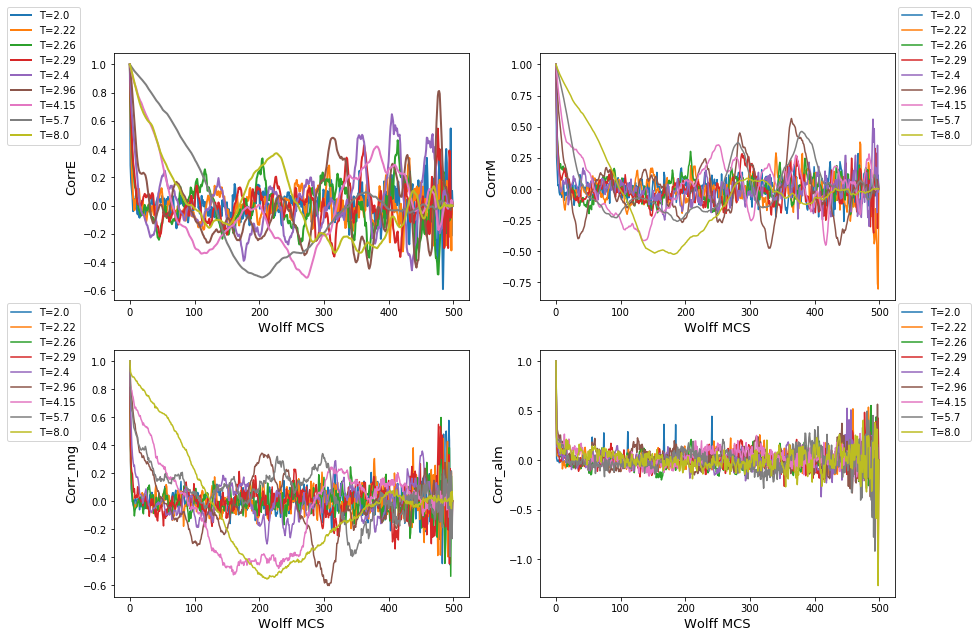

In [51]:
%matplotlib inline
fig = plt.figure(figsize=(14,10))
ax1 = fig.add_subplot(2,2,1); ax2 = fig.add_subplot(2,2,2); ax3 = fig.add_subplot(2,2,3); ax4 = fig.add_subplot(2,2,4)
t = np.arange(len(LcorrEdata[0][0]))
i = 3 # index of scales
l = 10; k = 35
step = 3

for j, item in enumerate(temperatures[l:k:step]):
    ax1.plot(t,LcorrEdata[i][j*step+l], linewidth=2, label=('T={}'.format(np.around(item,2))))
    ax2.plot(t, LcorrMdata[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    ax3.plot(t, Lcorr_nng_data[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    ax4.plot(t, Lcorr_alm_data[i][j*step+l], label=('T={}'.format(np.around(item,2))))
    
ax1.set_xlabel('Wolff MCS',fontsize=13); ax1.set_ylabel('CorrE', fontsize=13)
ax2.set_xlabel('Wolff MCS',fontsize=13); ax2.set_ylabel('CorrM', fontsize=13)
ax3.set_xlabel('Wolff MCS',fontsize=13); ax3.set_ylabel('Corr_nng', fontsize=13)
ax4.set_xlabel('Wolff MCS',fontsize=13); ax4.set_ylabel('Corr_alm', fontsize=13)
ax1.legend(loc=(-0.3,0.63)); ax2.legend(loc=(1.01,0.63)); ax3.legend(loc=(-0.3,0.63)); ax4.legend(loc=(1.01,0.63))

print('L = %d'%(possibleScales[i]))
#print('Correlation time (decay length) of the energy(nng):', LtauE[i])
#print('Correlation time (decay length) of the magnetization:', LtauM[i])


### Average Energy

In [52]:
scales = [8, 16, 28, 32]
print(scales)
print(len(temperatures))
print(temperatures)

[8, 16, 28, 32]
35
[0.01       0.34       0.67       1.         1.2        1.33333333
 1.46666667 1.6        1.73333333 1.86666667 2.         2.11
 2.18002031 2.21939785 2.24154271 2.25399639 2.261      2.269
 2.27550956 2.28672738 2.30605888 2.33937254 2.39678145 2.49571334
 2.6662011  2.96       3.3        3.725      4.15       4.575
 5.         5.7        6.46666667 7.23333333 8.        ]


In [56]:
# Set system parameters (note that these are global!):
#scales = [10,16,24,32] # Lattice number
#temperatures = np.linspace(0.1, 8, 30) # Temperature (critical at around 2.27)
#temperatures = np.sort(np.random.normal(2.28,0.6,3))# Temperature (critical at around 2.27)

run = False
if run:
    Len_data = []; Len_err = []#; LtausE = []
    Lmag_data = []; Lmag_err = []
    Lnng_data = []; Lnng_err = []#; Ltaus_nng = []
    Lalm_data = []; Lalm_err = []
    L_CvEdata = []; L_Cv_nng_data = []; L_Cv_alm_data = []
    Lsusc_data = []

    for N in scales:
        t_eq = 1000
        t_prod = 25000
        t_sim = t_eq + t_prod
    
        en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))#; tausE = []
        mag_data = np.zeros(len(temperatures)); mag_err = np.zeros(len(temperatures))
        nng_data = np.zeros(len(temperatures)); nng_err = np.zeros(len(temperatures))#; taus_nng = []
        alm_data = np.zeros(len(temperatures)); alm_err = np.zeros(len(temperatures))
    
        CvEdata = np.zeros(len(temperatures)); Cv_nng_data = np.zeros(len(temperatures))
        Cv_alm_data = np.zeros(len(temperatures)); susc_data = np.zeros(len(temperatures))
    
        # Initial lattice configuration
        lattice = -1*np.ones((N,N))  
        # lattice = np.random.choice([1,-1],size=(N,N))
  
        for j,T in enumerate(temperatures):
            #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
            # (only need first two values for metropolis)
            A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
            print('Performing simulation with T = ', T, 'and N = ', N)
            C, E, M, ALM = simulate_eff(lattice)
            clear_output(wait=True)
    
            lattice = np.copy(C[-1])
    
            nng = ALM[:,0]; alm = ALM[:,1]
    
            en_data[j] = np.mean(E[t_eq:]); en_err[j] = np.std(E[t_eq:])#; tausE[j] = tauE
            mag_data[j] = np.mean(abs(M[t_eq:])); mag_err[j] = np.std(abs(M[t_eq:]))
            nng_data[j] = np.mean(nng[t_eq:]); nng_err[j] = np.std(nng[t_eq:])
            alm_data[j] = np.mean(alm[t_eq:]); alm_err[j] = np.std(alm[t_eq:])
    
            CvEdata[j] = specific_heat(E[t_eq:]); Cv_nng_data[j] = specific_heat(nng[t_eq:])
            Cv_alm_data[j] = specific_heat(alm[t_eq:]); susc_data[j] = susceptiblity(abs(M[t_eq:]))
    
        Len_data.append(en_data); Len_err.append(en_err)#; LtausE.append(tausE)
        Lmag_data.append(mag_data); Lmag_err.append(mag_err)
        Lnng_data.append(nng_data); Lnng_err.append(nng_err)#; Ltaus_nng.append(taus_nng)
        Lalm_data.append(alm_data); Lalm_err.append(alm_err)
        L_CvEdata.append(CvEdata); L_Cv_nng_data.append(Cv_nng_data); L_Cv_alm_data.append(Cv_alm_data)
        Lsusc_data.append(susc_data)
        
else:
    Ldata = pickle.load(open('2Dfinite_size_scaling_data.p', 'rb'))
    Len_data = Ldata['Len_data']; Len_err = Ldata['Len_err']; L_CvEdata = Ldata['L_CvEdata']
    Lnng_data = Ldata['Lnng_data']; Lnng_err = Ldata['Lnng_err']; L_Cv_nng_data = Ldata['L_Cv_nng_data']
    temperatures = Ldata['temperatures']; scales = Ldata['scales']
    
    LdataALM = pickle.load(open('2Dfinite_size_scaling_dataALM.p', 'rb'))
    Lalm_data = LdataALM['Lalm_data']; Lalm_err = LdataALM['Lalm_err']; L_Cv_alm_data = LdataALM['L_Cv_alm_data']

    Ldata_mag = pickle.load(open('2Dfinite_size_scaling_data_mag.p', 'rb'))
    Lmag_data= Ldata_mag['Lmag_data']; Lmag_err = Ldata_mag['Lmag_err']; Lsusc_data = Ldata_mag['Lsusc_data']


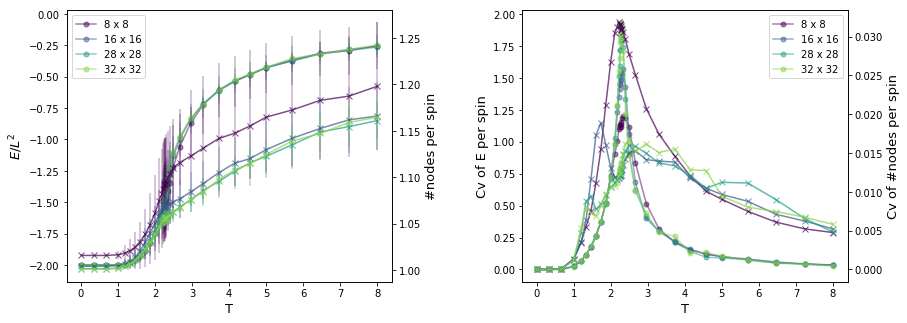

In [57]:
# Energy ~ Number of Nodes
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5))
fig4.subplots_adjust(wspace=0.4)
# energy:
ax41 = fig4.add_subplot(1,2,1); ax42 = ax41.twinx()
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$E/L^2$', fontsize=13)#, color='y')
ax42.set_ylabel('#nodes per spin', fontsize=13)#, color='r')
# specific heat:
ax43 = fig4.add_subplot(1,2,2); ax44 =ax43.twinx()
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('Cv of E per spin', fontsize=13)
ax44.set_ylabel('Cv of #nodes per spin', fontsize=13)

for i,L in enumerate(scales):
    # energy:
    ax41.plot(temperatures, Len_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Len_data[i]/(L**2), yerr=Len_err[i]/(L**2), alpha=0.3, linestyle='', color=cm.viridis(i*70))
    ax42.plot(temperatures, Lnng_data[i]/(L**2), marker='x',markersize=6, alpha=0.7, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    ax42.errorbar(temperatures, Lnng_data[i]/(L**2), yerr=Lnng_err[i]/(L**2), linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # specific heat:
    ax43.plot(temperatures, L_CvEdata[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    ax44.plot(temperatures, L_Cv_nng_data[i]/(L**2), marker='x', markersize=6, alpha=0.7, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    Ldata = {'Len_data': Len_data, 'Len_err': Len_err, 'Lnng_data': Lnng_data, 'Lnng_err': Lnng_err, 'L_CvEdata': L_CvEdata, 
             'L_Cv_nng_data': L_Cv_nng_data, 'temperatures': temperatures, 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata, open('2Dfinite_size_scaling_data.p', 'wb'))

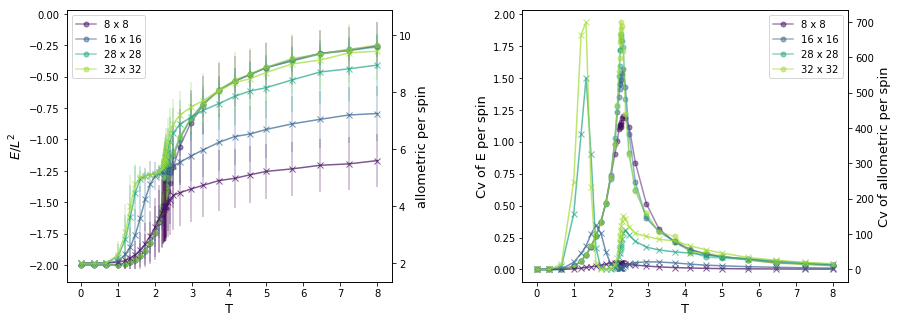

In [58]:
# Energy ~ Allometric Scale
%matplotlib inline
save = False

figalm = plt.figure(figsize=(14,5))
figalm.subplots_adjust(wspace=0.4)
# energy:
axalm1 = figalm.add_subplot(1,2,1); axalm2 = axalm1.twinx()
axalm1.set_xlabel('T',fontsize=13)
axalm1.set_ylabel('$E/L^2$', fontsize=13)#, color='y')
axalm2.set_ylabel('allometric per spin', fontsize=13)#, color='r')
# specific heat:
axalm3 = figalm.add_subplot(1,2,2); axalm4 =axalm3.twinx()
axalm3.set_xlabel('T',fontsize=13)
axalm3.set_ylabel('Cv of E per spin', fontsize=13)
axalm4.set_ylabel('Cv of allometric per spin', fontsize=13)

for i,L in enumerate(scales):
    # energy:
    axalm1.plot(temperatures, Len_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70+10))
    axalm1.errorbar(temperatures, Len_data[i]/(L**2), yerr=Len_err[i]/(L**2), alpha=0.3, linestyle='', color=cm.viridis(i*70))
    axalm2.plot(temperatures, Lalm_data[i]/(L**2), marker='x',markersize=6, alpha=0.7, label='%d x %d'%(L,L), color=cm.viridis(i*70+10))
    axalm2.errorbar(temperatures, Lalm_data[i]/(L**2), yerr=Lalm_err[i]/(L**2), linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # specific heat:
    axalm3.plot(temperatures, L_CvEdata[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), 
                color=cm.viridis(i*70+10))
    axalm4.plot(temperatures, L_Cv_alm_data[i]/(L**2), marker='x', markersize=6, alpha=0.7, label='%d x %d'%(L,L), 
                color=cm.viridis(i*70+10))
    
axalm1.legend()
axalm3.legend()

if save:
    # Save data as dictionary:
    LdataALM = {'Len_data': Len_data, 'Len_err': Len_err, 'Lalm_data': Lalm_data, 'Lalm_err': Lalm_err, 'L_CvEdata': L_CvEdata,
                'L_Cv_alm_data': L_Cv_alm_data, 'temperatures': temperatures, 
                'scales': scales, 't_prod': t_prod}
    pickle.dump(LdataALM, open('2Dfinite_size_scaling_dataALM.p', 'wb'))

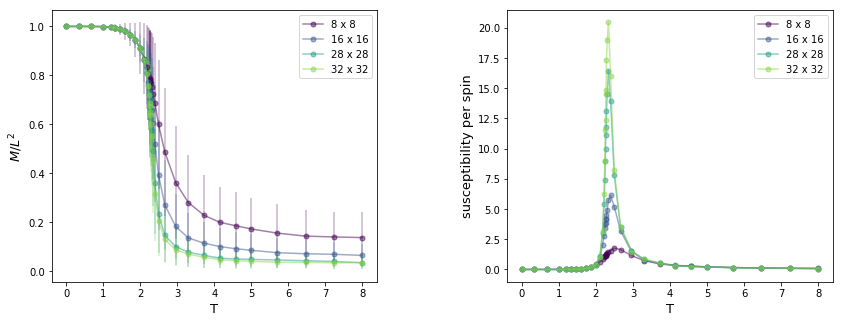

In [59]:
# magnetization ~ susceptibility
%matplotlib inline
save = False

fig4 = plt.figure(figsize=(14,5))
fig4.subplots_adjust(wspace=0.4)
# magnetization:
ax41 = fig4.add_subplot(1,2,1)
ax41.set_xlabel('T',fontsize=13)
ax41.set_ylabel('$M/L^2$', fontsize=13)#, color='y')

# susceptibility:
ax43 = fig4.add_subplot(1,2,2)
ax43.set_xlabel('T',fontsize=13)
ax43.set_ylabel('susceptibility per spin', fontsize=13)

for i,L in enumerate(scales):
    # magnetization:
    ax41.plot(temperatures, Lmag_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
    ax41.errorbar(temperatures, Lmag_data[i]/(L**2), yerr=Lmag_err[i]/(L**2), alpha=0.3, linestyle='', color=cm.viridis(i*70))
    #ax42.errorbar(temperatures, Lnng_data[i], yerr=Lnng_err[i], linestyle='', alpha=0.3, color=cm.viridis(i*70))
    # susceptibility:
    ax43.plot(temperatures, Lsusc_data[i]/(L**2), marker='o', markersize=5, alpha=0.5, label='%d x %d'%(L,L), color=cm.viridis(i*70))
ax41.legend()
ax43.legend()

if save:
    # Save data as dictionary:
    Ldata_mag = {'Lmag_data': Lmag_data, 'Lmag_err': Lmag_err, 'Lsusc_data': Lsusc_data, 'temperatures': temperatures, 
                 'scales': scales, 't_prod': t_prod}
    pickle.dump(Ldata_mag, open('2Dfinite_size_scaling_data_mag.p', 'wb'))

# Free energy 

In [60]:
def exc_free_energy_calc():
    f = np.zeros(len(temperatures))
    def integrand(phi, k):
        return np.log((1+np.sqrt(1-(k*np.sin(phi))**2))/2)
    for i,T in enumerate(temperatures):
        a = -T*np.log(2*np.cosh(2/T))
        k = 2*np.sinh(2/T)/(np.cosh(2/T)**2)
        I = integrate.quad(integrand, 0, np.pi, args=(k))
        b = -(T/(2*np.pi))*I[0]
        f[i] = a+b
    return f

In [61]:
def create_energy_hist(x, mode):
    lowB = np.min(x)
    upperB = np.max(x)
    n = round(abs(upperB-lowB)*50)+2
    if mode == 'nng':
        n = round(abs(upperB-lowB)*0.15)+2
    if mode == 'alm':
        n = round(abs(upperB-lowB)*50)+2
    print(n)
    bin_edges = np.linspace(lowB,upperB,n)
    #bin_edges = np.histogram_bin_edges(en, bins='doane')
    #h, b = stats.histogram(en, bins='blocks')
    h, b = np.histogram(x, bins=bin_edges)#, density=True)
    idx = np.where(h>0)
    h = h[idx]
    b = b[idx]
    return h, b
    

In [62]:
def free_energy_calc(nE, en, g, temp):
    nE = Decimal(nE); g = Decimal(g) #;en = Decimal(en);  temp = Decimal(temp)
    r = float(g/nE)
    f = -temp*np.log(r) + en
    return f

In [63]:
def g_transfer(nE1, en1, g1, nE2, en2, temp):
    nE1 = Decimal(nE1); en1 = Decimal(en1); g1 = Decimal(g1); nE2 = Decimal(nE2); en2 = Decimal(en2); temp = Decimal(temp)
    boltz_exp = np.exp(-(1/temp)*(en1-en2))
    #print('bExp', boltz_exp)
    g2 = round(g1*(nE2/nE1)*boltz_exp)
    return g2

In [64]:
def find_intersection(x_targ, y_targ, x2, y2):
    m = len(x_targ)
    n = len(x2)
    min_dist = 10000
    coords = np.zeros((2,2))
    for i in range(m):
        for j in range(n):
            d = (x2[j]-x_targ[i])**2 + (y2[j]-y_targ[i])**2
            if d < min_dist:
                min_dist = d
                coords[0][0] = x_targ[i]
                coords[0][1] = y_targ[i]
                coords[1][0] = x2[j]
                coords[1][1] = y2[j]
    return(coords)


In [65]:
def free_energyVStemp(hists, bins, g0):
    f = np.zeros(len(temperatures))
    idx = np.argmax(hists[0])
    nE = hists[0][idx]
    en = bins[0][idx]
    g = g0
    
    for i,temperature in enumerate(temperatures):
        #print('g',g)
        f[i] = free_energy_calc(nE, en, g, temperature)   
        
        if i == (len(temperatures)-1):
            break
        #print(i)
        hist1 = hists[i]
        bins1 = bins[i]
        hist2 = hists[i+1]
        bins2 = bins[i+1]
        l = np.argmax(hist1)
        k = np.argmax(hist2)+1
        #print('l:', l, 'k:', k)
        if bins2[k-1] < bins1[l]:
            raise ValueError('Data of consecutive histograms %d and %d are not consecutive'%(i,i+1))
          
        # get intersection
        coords = find_intersection(bins1[l:], hist1[l:], bins2[:k], hist2[:k])
        
        en1 = coords[0][0]
        nE1 = coords[0][1]
               
        g = g_transfer(nE, en, g, nE1, en1, temperature)
        #print(coords)
        en = coords[1][0]
        nE = coords[1][1]  
    return f
            

In [66]:
def check_visual(i, hists, bins):

    fig = plt.figure(figsize=(7,5))
    ax = fig.add_subplot(1,1,1)
    
    b1 = bins[i]
    h1 = hists[i]
    l = np.argmax(h1)
    temperature1 = temperatures[i]
    
    b2 = bins[i+1]
    h2 = hists[i+1]
    k = np.argmax(h2)+1
    temperature2 = temperatures[i+1]
    
    ax.plot(b1/(N**2), h1,label='T=%.2f'%(temperature1), markersize=3, linestyle='-', marker='o', linewidth=1, color='#1f77b4')
    ax.plot(b1[l:]/(N**2), h1[l:], markersize=6, color='#1f77b4', marker='o', linewidth=2)
    
    ax.plot(b2/(N**2), h2,label='T=%.2f'%(temperature2), markersize=3, linestyle='-', marker='o', linewidth=1, color='orange')
    ax.plot(b2[:k]/(N**2), h2[:k], markersize=6, color='orange', marker='o', linewidth=2)
    
    ax.legend()
    #ax5.set_yscale('log')

### Vary temperature for free energy

In [67]:
temperatures = np.geomspace(0.1, 6, 20)
print(temperatures)

[0.1        0.12404718 0.15387704 0.19088013 0.23678143 0.29372069
 0.36435224 0.4519687  0.56065444 0.69547604 0.86271844 1.07017792
 1.32752557 1.64675808 2.04275702 2.53398254 3.14333397 3.89921726
 4.83686919 6.        ]


In [68]:
lowRange = np.linspace(0.01, 1, 4); highRange = np.linspace(3.3, 6, 5)
crRange = np.arange(1.3, 3, 0.244)#np.random.normal(2.28,0.5,20)
temperatures = np.sort(np.concatenate((lowRange,crRange,highRange)))
#temperatures = np.arange(0.1, 8, 0.19)
print(len(temperatures))
print(temperatures)

16
[0.01  0.34  0.67  1.    1.3   1.544 1.788 2.032 2.276 2.52  2.764 3.3
 3.975 4.65  5.325 6.   ]


In [69]:
lowRange = np.linspace(0.01, 1, 4); highRange = np.linspace(4, 6, 6)
crRange = np.arange(1.2, 3.8, 0.18)#np.random.normal(2.28,0.5,20)
temperatures = np.sort(np.concatenate((lowRange,crRange,highRange)))
#temperatures = np.arange(0.1, 8, 0.19)
print(len(temperatures))
print(temperatures)

25
[0.01 0.34 0.67 1.   1.2  1.38 1.56 1.74 1.92 2.1  2.28 2.46 2.64 2.82
 3.   3.18 3.36 3.54 3.72 4.   4.4  4.8  5.2  5.6  6.  ]


In [70]:
run = False
if run:

    # Set system parameters (note that these are global!):
    N = 10 # Lattice number
    #temperatures = np.linspace(0.1, 6, 20) # Temperature (critical at around 2.27)
    #temperatures = np.sort(np.random.normal(2.28,0.6,50))# Temperature (critical at around 2.27)
    t_eq = 1000
    t_prod = 40000
    t_sim = t_eq + t_prod

    en_data = np.zeros(len(temperatures))#; en_err = []; tausE = []
    nng_data = np.zeros(len(temperatures))#; nng_err = []; taus_nng = []
    alm_data = np.zeros(len(temperatures)) 

    en_hist_data = []; en_bin_edges_data = []
    nng_hist_data = []; nng_bin_edges_data = []
    alm_hist_data = []; alm_bin_edges_data = []

    # Initial lattice configuration
    lattice = -1*np.ones((N,N))  
    # lattice = np.random.choice([1,-1],size=(N,N))
  

    for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance probability 
        # (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T)
        C, E, M, ALM = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
    
        nng = ALM[:,0]; alm = ALM[:,1]
        
        #corrE = corr_func_calc(E[t_eq:])
        #tauE = corr_time(corrE,0.97)
        #eE = np.sqrt(2*tauE/len(E[t_eq:]))*np.std(E[t_eq:])
    
        #corr_nng = corr_func_calc(nng[t_eq:])
        #tau_nng = corr_time(corr_nng, 0.97)
        #e_nng = np.sqrt(2*tau_nng/len(nng[t_eq:]))*np.std(nng[t_eq:])
    
        en_hist, en_bin_edges = create_energy_hist(E[t_eq:], 'en')
        nng_hist, nng_bin_edges = create_energy_hist(nng[t_eq:], 'nng')
        alm_hist, alm_bin_edges = create_energy_hist(alm[t_eq:], 'alm')
    
        en_data[j] = np.mean(E[t_eq:]) #en_data.append(np.mean(E[t_eq:]))#; en_err.append(eE); tausE.append(tauE)
        nng_data[j] = np.mean(nng[t_eq:])  #nng_data.append(np.mean(nng[t_eq:]))#; nng_err.append(e_nng); taus_nng.append(tau_nng)
        alm_data[j] = np.mean(alm[t_eq:])
    
        en_hist_data.append(en_hist/t_prod); en_bin_edges_data.append(en_bin_edges)
        nng_hist_data.append(nng_hist/t_prod); nng_bin_edges_data.append(nng_bin_edges)
        alm_hist_data.append(alm_hist/t_prod); alm_bin_edges_data.append(alm_bin_edges)
    

### Visually check histograms 

Ising energy:

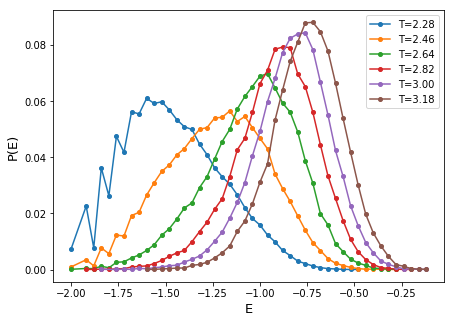

In [52]:
%matplotlib inline
fig5 = plt.figure(figsize=(7,5))
ax5 = fig5.add_subplot(1,1,1)
ax5.set_xlabel('E', fontsize=13)
ax5.set_ylabel('P(E)', fontsize=13)

l = 10
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax5.plot(en_bin_edges_data[l+i]/(N**2), en_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax5.legend()
#ax5.set_yscale('log')

In [53]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(en_hist_data), bins=wg.fixed(en_bin_edges_data), i=(0,len(temperatures)-2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

<function __main__.check_visual(i, hists, bins)>

number of nodes

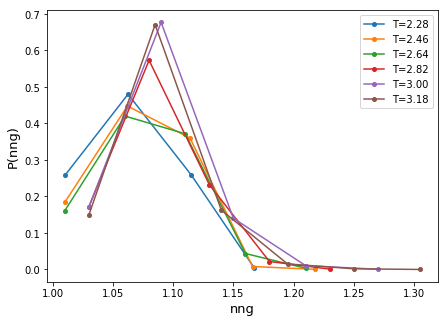

In [54]:
%matplotlib inline
fig6 = plt.figure(figsize=(7,5))
ax6 = fig6.add_subplot(1,1,1)
ax6.set_xlabel('nng', fontsize=13)
ax6.set_ylabel('P(nng)', fontsize=13)

l = 10
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax6.plot(nng_bin_edges_data[l+i]/(N**2), nng_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax6.legend()
#ax5.set_yscale('log')

In [55]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(nng_hist_data), bins=wg.fixed(nng_bin_edges_data), i=(0,len(temperatures)-2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

<function __main__.check_visual(i, hists, bins)>

allometric scale

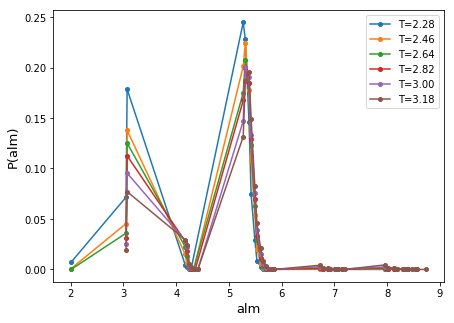

In [56]:
%matplotlib inline
figALM = plt.figure(figsize=(7,5))
ax = figALM.add_subplot(1,1,1)
ax.set_xlabel('alm', fontsize=13)
ax.set_ylabel('P(alm)', fontsize=13)

l = 10
k = 15
for i,temperature in enumerate(temperatures[l:k+1]):
    ax.plot(alm_bin_edges_data[l+i]/(N**2), alm_hist_data[l+i],label='T=%.2f'%(temperature), markersize=4, linestyle='-', 
             marker='o')
    
ax.legend()
#ax5.set_yscale('log')

In [57]:
%matplotlib inline
wg.interact(check_visual, hists=wg.fixed(alm_hist_data), bins=wg.fixed(alm_bin_edges_data), i=(0,len(temperatures)-2))
print(alm_data[13]/(N**2))

interactive(children=(IntSlider(value=11, description='i', max=23), Output()), _dom_classes=('widget-interact'…

4.9891815


In [58]:
save = False
if save:
    hs_bs_data = {'en_hist_data': en_hist_data, 'en_bin_edges_data': en_bin_edges_data, 'nng_hist_data': nng_hist_data, 
                  'nng_bin_edges_data': nng_bin_edges_data, 'alm_hist_data': alm_hist_data, 
                  'alm_bin_edges_data': alm_bin_edges_data, 'temperatures': temperatures, 'N': N}
    pickle.dump(hs_bs_data, open('2Denergy_histograms.p', 'wb'))

# Old

### Vary system size

In [161]:
lowRange = np.linspace(0.01, 1, 4)
midlowRange = np.linspace(1.2, 2, 7)
clowRange = 2.27 - np.geomspace(0.009, 0.16, 6)
chighRange = 2.26 + np.geomspace(0.009, 0.7, 9)
midhighRange = np.linspace(3.3, 5, 5)
highRange = np.linspace(5.7, 8, 4)

temperatures = np.sort(np.concatenate((lowRange,midlowRange, clowRange, chighRange, midhighRange, highRange)))
print(len(temperatures))
print(temperatures[:])
print(np.diff(temperatures[:]))

35
[0.01       0.34       0.67       1.         1.2        1.33333333
 1.46666667 1.6        1.73333333 1.86666667 2.         2.11
 2.18002031 2.21939785 2.24154271 2.25399639 2.261      2.269
 2.27550956 2.28672738 2.30605888 2.33937254 2.39678145 2.49571334
 2.6662011  2.96       3.3        3.725      4.15       4.575
 5.         5.7        6.46666667 7.23333333 8.        ]
[0.33       0.33       0.33       0.2        0.13333333 0.13333333
 0.13333333 0.13333333 0.13333333 0.13333333 0.11       0.07002031
 0.03937754 0.02214487 0.01245368 0.00700361 0.008      0.00650956
 0.01121782 0.0193315  0.03331366 0.05740891 0.09893188 0.17048777
 0.2937989  0.34       0.425      0.425      0.425      0.425
 0.7        0.76666667 0.76666667 0.76666667]


In [111]:
lowRange = np.linspace(0.01, 1, 4); highRange = np.linspace(5, 8, 4)
clowRange = 2.27 - np.geomspace(0.009, 1, 16)
chighRange = 2.27 + np.geomspace(0.005, 2.3, 18)
temperatures = np.sort(np.concatenate((lowRange,clowRange,chighRange,highRange)))
print(len(temperatures))
print(temperatures[20:])
print(np.diff(temperatures[20:]))

42
[2.275      2.27717138 2.28028574 2.2847526  2.2911593  2.30034828
 2.31352782 2.33243091 2.35954318 2.39842966 2.45420361 2.53419887
 2.64893417 2.81349629 3.04952383 3.38805253 3.87359621 4.57
 5.         6.         7.         8.        ]
[0.00217138 0.00311436 0.00446685 0.0064067  0.00918898 0.01317954
 0.0189031  0.02711226 0.03888648 0.05577395 0.07999526 0.1147353
 0.16456212 0.23602754 0.3385287  0.48554368 0.69640379 0.43
 1.         1.         1.        ]


In [72]:
lowRange = 2.27 - np.geomspace(0.009, 2.26, 15)
highRange = np.geomspace(0.005, 5.7, 21)+2.27
temperatures = np.sort(np.concatenate((lowRange,highRange)))
print(len(temperatures))
print(temperatures)

36
[0.01       0.74703668 1.24370917 1.57840562 1.80395006 1.95593939
 2.0583616  2.12738163 2.17389268 2.20523543 2.22635661 2.2405897
 2.25018106 2.25664446 2.261      2.275      2.27710911 2.28010789
 2.28437162 2.29043389 2.29905335 2.31130869 2.32873361 2.35350874
 2.38873457 2.43881943 2.51003119 2.61128163 2.75524175 2.95992741
 3.250954   3.66474202 4.25307495 5.08957967 6.27894052 7.97      ]


In [50]:
temperatures = np.linspace(0.1, 8, 70)
print(len(temperatures))
print(temperatures)

70
[0.1        0.21449275 0.32898551 0.44347826 0.55797101 0.67246377
 0.78695652 0.90144928 1.01594203 1.13043478 1.24492754 1.35942029
 1.47391304 1.5884058  1.70289855 1.8173913  1.93188406 2.04637681
 2.16086957 2.27536232 2.38985507 2.50434783 2.61884058 2.73333333
 2.84782609 2.96231884 3.07681159 3.19130435 3.3057971  3.42028986
 3.53478261 3.64927536 3.76376812 3.87826087 3.99275362 4.10724638
 4.22173913 4.33623188 4.45072464 4.56521739 4.67971014 4.7942029
 4.90869565 5.02318841 5.13768116 5.25217391 5.36666667 5.48115942
 5.59565217 5.71014493 5.82463768 5.93913043 6.05362319 6.16811594
 6.2826087  6.39710145 6.5115942  6.62608696 6.74057971 6.85507246
 6.96956522 7.08405797 7.19855072 7.31304348 7.42753623 7.54202899
 7.65652174 7.77101449 7.88550725 8.        ]


In [38]:
lowRange = np.linspace(0.01, 1, 4); highRange = np.linspace(4, 6, 6)
crRange = #np.random.normal(2.28,0.2,15)#np.arange(1.2, 3.8, 0.18)#
temperatures = np.sort(np.concatenate((lowRange,crRange,highRange)))
#temperatures = np.arange(0.1, 8, 0.19)
print(len(temperatures))
print(temperatures)

25
[0.01       0.34       0.67       1.         1.98174404 2.0401483
 2.04774936 2.05366275 2.11770969 2.27870769 2.29163875 2.29505977
 2.3126022  2.35547078 2.39242722 2.41683432 2.41866175 2.56421481
 2.63913695 4.         4.4        4.8        5.2        5.6
 6.        ]


### Plot free energy

In [62]:
f_exact = exc_free_energy_calc()
en_fr = free_energyVStemp(en_hist_data, en_bin_edges_data, 2)
nng_fr = free_energyVStemp(nng_hist_data, nng_bin_edges_data, 1)
#alm_fr = free_energyVStemp(alm_hist_data, alm_bin_edges_data, 1)
print(en_fr)
print(nng_fr)
#print(alm_fr)

ValueError: Data of consecutive histograms 18 and 19 are not consecutive

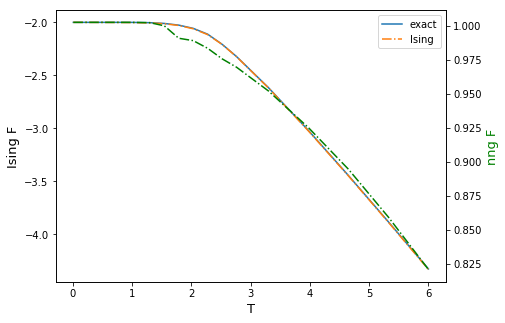

In [71]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1); ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('Ising F', fontsize=13)
ax8.set_ylabel('nng F', fontsize=13, color='g')

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_fr/(N**2), label='Ising', linestyle='-.')
ax8.plot(temperatures, nng_fr/(N**2), label='#nodes', linestyle='-.', color='g')
#ax8.plot(temperatures, alm_fr/(N**2), label='allometric', linestyle='-.')

ax7.legend()

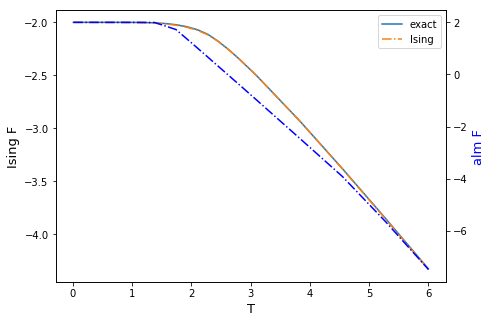

In [129]:
%matplotlib inline
fig7 = plt.figure(figsize=(7,5))
ax7 = fig7.add_subplot(1,1,1); ax8 = ax7.twinx()
ax7.set_xlabel('T', fontsize=13)
ax7.set_ylabel('Ising F', fontsize=13)
ax8.set_ylabel('alm F', fontsize=13, color='b')

ax7.plot(temperatures, f_exact, label='exact')
ax7.plot(temperatures, en_fr/(N**2), label='Ising', linestyle='-.')
#ax8.plot(temperatures, nng_fr/(N**2), label='#nodes', linestyle='-.', color='g')
ax8.plot(temperatures, alm_fr/(N**2), label='allometric', linestyle='-.', color='b')

ax7.legend()

Entropy:

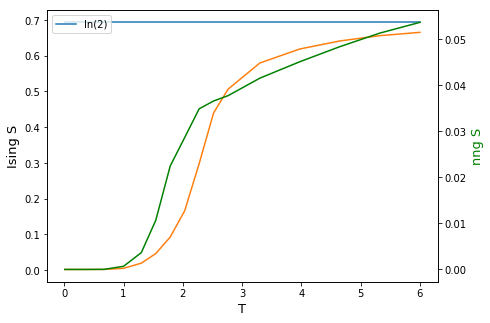

In [67]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1); ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('Ising S', fontsize=13)
ax1.set_ylabel('nng S', fontsize=13, color='g')

en_S = (en_data-en_fr)/((N**2)*temperatures)
nng_S = (nng_data-nng_fr)/((N**2)*temperatures)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)), label='ln(2)')
ax.plot(temperatures, en_S)
ax1.plot(temperatures, nng_S, color='g')

ax.legend(loc='upper left')

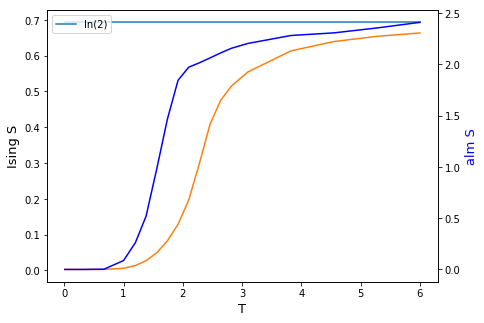

In [131]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1); ax1 = ax.twinx()
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('Ising S', fontsize=13)
ax1.set_ylabel('alm S', fontsize=13, color='b')

en_S = (en_data-en_fr)/((N**2)*temperatures)
alm_S = (alm_data-alm_fr)/((N**2)*temperatures)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)), label='ln(2)')
ax.plot(temperatures, en_S)
ax1.plot(temperatures, alm_S, color='b')

ax.legend(loc='upper left')

### Vary system size for free energy

In [33]:
temperatures = np.geomspace(0.1, 6, 10)
print(temperatures)

[0.1        0.15760586 0.24839607 0.39148676 0.61700608 0.97243774
 1.53261886 2.41549714 3.80696505 6.        ]


In [75]:
lowRange = np.linspace(0.01, 1, 4); highRange = np.linspace(3.3, 6, 5)
crRange = np.arange(1.3, 3, 0.244)#np.random.normal(2.28,0.5,20)
temperatures = np.sort(np.concatenate((lowRange,crRange,highRange)))
#temperatures = np.arange(0.1, 8, 0.19)
print(len(temperatures))
print(temperatures)

16
[0.01  0.34  0.67  1.    1.3   1.544 1.788 2.032 2.276 2.52  2.764 3.3
 3.975 4.65  5.325 6.   ]


In [76]:
# Set system parameters (note that these are global!):
scales = [24, 32] # Lattice number
#low_range = np.linspace(0.1, 3, 20); high_range = np.linspace(3.5, 6, 5)
#temperatures = np.concatenate((low_range, high_range))
#temperatures = np.linspace(0.1, 5, 25) # Temperature (critical at around 2.27)

Len_data = []#; Len_err = []
Lnng_data = []#; Lnng_err = []

Len_hist_data = []; Len_bin_edges_data = []
Lnng_hist_data = []; Lnng_bin_edges_data = []

Len_fr = []; Lnng_fr = []; Lalm_fr = []

for N in scales:
    t_eq = (N**2)*10
    t_prod = 30000
    t_sim = t_eq + t_prod
    
    en_data = np.zeros(len(temperatures)); en_err = np.zeros(len(temperatures))
    nng_data = np.zeros(len(temperatures)); nng_err = np.zeros(len(temperatures))
    
    en_hist_data = []; en_bin_edges_data = []
    nng_hist_data = []; nng_bin_edges_data = []

    # Initial lattice configuration
    lattice = -1*np.ones((N,N))  
    # lattice = np.random.choice([1,-1],size=(N,N))
  
    for j,T in enumerate(temperatures):
        #exp = np.array([np.exp(-8/T),np.exp(-4/T),1,np.exp(4/T),np.exp(8/T)]) # Store possible values of the acceptance 
        #probability (only need first two values for metropolis)
        A_wolff = np.exp(-2/T) # Needed for acceptance value for Wolff
    
        print('Performing simulation with T = ', T, 'and N = ', N)
        C, E, M, ALM = simulate_eff(lattice)
        clear_output(wait=True)
    
        lattice = C[-1]
    
        nng = ALM[:,0]; alm = ALM[:,1]
        
        en_hist, en_bin_edges = create_energy_hist(E[t_eq:], 'en')
        nng_hist, nng_bin_edges = create_energy_hist(nng[t_eq:], 'nng')
        
        en_data[j] = np.mean(E[t_eq:])#; en_err[j] = np.std(E[t_eq::snap])
        nng_data[j] = np.mean(nng[t_eq:])#; nng_err[j] = np.std(nng[t_eq:])
        
        en_hist_data.append(en_hist/t_prod); en_bin_edges_data.append(en_bin_edges)
        nng_hist_data.append(nng_hist/t_prod); nng_bin_edges_data.append(nng_bin_edges)
        
    Len_data.append(en_data); #Len_err.append(en_err)
    Lnng_data.append(nng_data); #Lnng_err.append(nng_err)
    Len_hist_data.append(en_hist_data); Len_bin_edges_data.append(en_bin_edges_data)
    Lnng_hist_data.append(nng_hist_data); Lnng_bin_edges_data.append(nng_bin_edges_data)
    
    en_fr = free_energyVStemp(en_hist_data, en_bin_edges_data, 2)
    nng_fr = free_energyVStemp(nng_hist_data, nng_bin_edges_data, 1)
    alm_fr = free_energyVStemp(alm_hist_data, alm_bin_edges_data, 1)
    Len_fr.append(en_fr)
    Lnng_fr.append(nng_fr)

13602.0
22.0


ValueError: Data of consecutive histograms 8 and 9 are not consecutive

In [35]:
f_exact = exc_free_energy_calc()
#Len_fr = []
#for i,L in enumerate(scales):
    #print(L)
    #fr = free_energyVStemp(Len_hist_data[i], Len_bin_edges_data[i], 2)
    #Len_fr.append(fr)

8
12


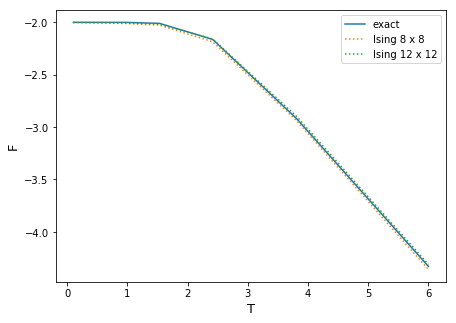

In [36]:
%matplotlib inline

fig8 = plt.figure(figsize=(7,5))
ax8 = fig8.add_subplot(1,1,1)
ax8.set_xlabel('T', fontsize=13)
ax8.set_ylabel('F', fontsize=13)

ax8.plot(temperatures, f_exact, label='exact')

for i,L in enumerate(scales):
    ax8.plot(temperatures, Len_fr[i]/(L**2), label='Ising %d x %d'%(L,L), linestyle=':')
    
ax8.legend()


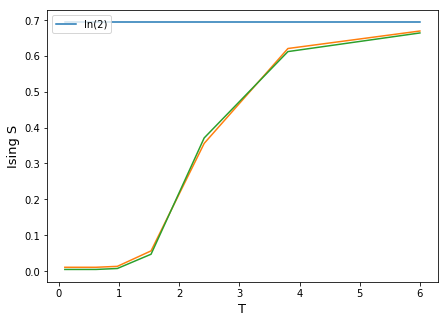

In [40]:
%matplotlib inline
fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(1,1,1)
ax.set_xlabel('T', fontsize=13)
ax.set_ylabel('Ising S', fontsize=13)
ax.plot(temperatures, np.tile(np.log(2), len(temperatures)), label='ln(2)')

for i,L in enumerate(scales):
    en_S = (Len_data[i]-Len_fr[i])/((L**2)*temperatures)
    ax.plot(temperatures, en_S)
    
ax.legend(loc='upper left')

In [41]:
save = False
if save:
    # Save data as dictionary:
    Lf_data = {'f_exact': f_exact, 'Len_fr': Len_fr, 'Len_data': Len_data, 'temperatures': temperatures, 'scales': scales}
    pickle.dump(Lf_data, open('free_energy_finite_size_scaling.p', 'wb'))